## p-value calculation for a coin

In [1]:
import math
from random import random
from scipy.stats import binom
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# binomial distribution
def prob_binom(k, N, p):
    return binom.pmf(k, N, p)
#    return math.comb(N, k) * p ** k * (1 - p) ** (N - k)

# calculate P-value for a coin assumin P(heads)=p:
def get_p_value(k, N, p=0.5):
    
    # probability to have observation 
    stat_value = prob_binom(k, N, p)

    p_val = stat_value

    # add all smaller probabilities for i < k (left tail)
    for i in range(0, k+1):
        prob = prob_binom(i, N, p)
        if prob < stat_value:
            p_val += prob
        else:
            break

    # add all smaller probabilities for i > k (right tail)
    for i in range(N, k-1, -1):
        prob = prob_binom(i, N, p)
        if prob < stat_value:
            p_val += prob
        else:
            break

    return p_val

In [3]:
# 1 - heads
# 0 - tails
N_FLIPS = 20
P0 = 0.5


observations = [int(random()<P0) for _ in range(N_FLIPS)]
get_p_value(sum(observations), len(observations))

0.38331031799316406

## Visualize p-value calculation

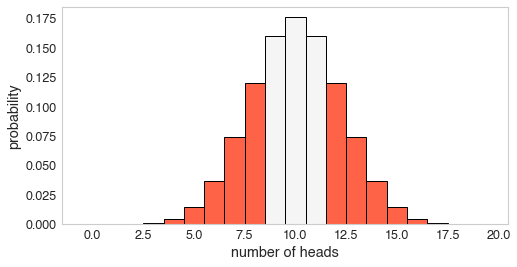

In [4]:
x = range(N_FLIPS)
y= [prob_binom(i, N_FLIPS, 0.5) for i in x]
data = list(zip(x, y))

# exact probability of observed outcome
obs_prob = prob_binom(sum(observations),
                      len(observations),
                      P0)


data_lower_prob = list(filter(lambda x: x[1]<=obs_prob, data))
data_higher_prob = list(filter(lambda x: x[1]>obs_prob, data))


fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(4)

plt.bar(*zip(*data_lower_prob), width=1, 
        color = 'tomato',
        edgecolor = 'black', lw = 1)


if data_higher_prob:
    plt.bar(*zip(*data_higher_prob), width=1, 
              color = 'whitesmoke',
              edgecolor = 'black', lw = 1)


plt.ylabel('probability')
plt.xlabel('number of heads')

plt.grid(False)
    

plt.show()

## Significance level, type I error

In [5]:
%%time
N_TESTS = 1000
N_FLIPS = 200
P0 = 0.5


p_values_log = []

# in all tests coins are fair:
for _ in range(N_TESTS):
    observations = [int(random()<P0) for _ in range(N_FLIPS)]
    p_value = get_p_value(sum(observations), len(observations))
    p_values_log.append(p_value)


CPU times: user 22.1 s, sys: 138 ms, total: 22.3 s
Wall time: 22.3 s


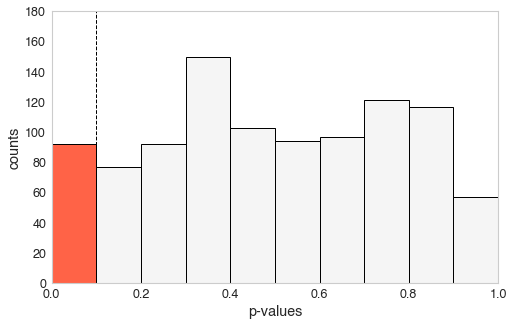

In [6]:
# selected significance level
alpha = 0.1

# number of histogram bins
bin_nums = 10


fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)

y, _, bars = ax.hist(p_values_log, bins=bin_nums, edgecolor = 'black', color='whitesmoke', lw = 1);

for bar in bars:
    if abs(bar.get_x()) <= alpha:
        bar.set_facecolor('tomato')

        
plt.vlines(alpha, 0, 1.2*max(y), colors='black', lw=1, linestyles='--')

plt.ylabel('counts')
plt.xlabel('p-values')
plt.ylim(0,1.2*max(y))
plt.xlim(0,1)
plt.grid(False)


plt.show()

In [7]:
H0_accept = len(list(filter(lambda x: x>=alpha, p_values_log)))
H0_reject = len(list(filter(lambda x: x<alpha, p_values_log)))


print(f'total number of trials: {N_TESTS}')
print(f'├─concluded coin is fair: {H0_accept}')
print(f'└─concluded coin is biased: {H0_reject}')

total number of trials: 1000
├─concluded coin is fair: 908
└─concluded coin is biased: 92


## Minimal Detectable Effect (MDE), Type II error

In [8]:
def plot_segmented_bar(ax, data, *,
                      thresh,
                      fill_colors):
    
    lower_thresh, upper_thresh = thresh[0], thresh[1]
    
    data_left = list(filter(lambda x: x[0]<=lower_thresh, data))
    data_middle = list(filter(lambda x: x[0]>lower_thresh and x[0]<upper_thresh, data))
    data_right = list(filter(lambda x: x[0]>=upper_thresh, data))

    plot_step_func(ax, data_left, fill_colors[0])
    plot_step_func(ax, data_middle, fill_colors[1], True)
    plot_step_func(ax, data_right, fill_colors[2])
    

def plot_step_func(ax, data, fill_color, show_area=False):
    data = list(data)
    x = [i[0]+0.5 for i in data]
    x.insert(0, x[0]-1)
    y = [i[1] for i in data]
    if show_area:
        print(sum(y))
    y.insert(0, y[0])    

    ax.step(x, y, color = 'black', lw = 1)
    ax.fill_between(x, y, color = fill_color, step="pre", alpha=1)

0.9113739198859054
0.3773712418025527


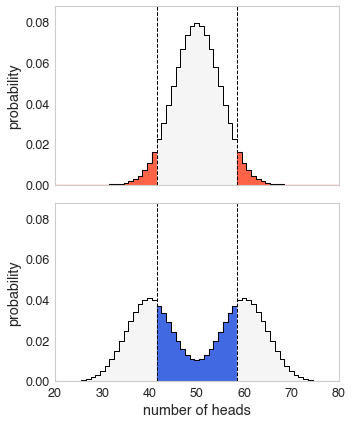

In [9]:
MDE = 0.2
alpha = 0.1
N_FLIPS = 100


p_sum = 0
for k in range(N_FLIPS):
    p_sum += prob_binom(k, N_FLIPS, P0)
    if p_sum >= alpha/2:
        lower_thresh = k-1
        break

        
p_sum = 0
for k in range(N_FLIPS,0,-1):
    p_sum += prob_binom(k, N_FLIPS, P0)
    if p_sum >= alpha/2:
        upper_thresh = k+1
        break


x = range(N_FLIPS)
x_min = 0.2*N_FLIPS
x_max = 0.8*N_FLIPS
y_H0 = [prob_binom(i, N_FLIPS, P0) for i in x]
data = list(zip(x, y_H0))


# initialize plots
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(6)

plot_segmented_bar(ax1, data, 
                   thresh=[lower_thresh, upper_thresh],
                   fill_colors=['tomato', 'whitesmoke', 'tomato'])


ax1.set_ylabel('probability')
ax1.set_xlabel(None)
ax1.set_xticklabels([])
ax1.set_ylim(0,1.1*max(y_H0))
#ax1.text(0,0.9*max(y_H0),
#f"""probability of HEADS
#P0={P0}""",fontsize=12)
ax1.grid(False)
ax1.vlines(lower_thresh+0.5, 0, 1.1*max(y_H0),colors='black', lw=1, linestyles='--')
ax1.vlines(upper_thresh-0.5, 0, 1.1*max(y_H0),colors='black', lw=1, linestyles='--')
ax1.set_xlim(x_min,x_max)

# plot H1 distribution: right
y_H1 = [0.5*prob_binom(i, N_FLIPS, P0*(1+MDE))+0.5*prob_binom(i, N_FLIPS, P0*(1-MDE)) for i in x]
data = list(zip(x, y_H1))


plot_segmented_bar(ax2, data, 
                   thresh=[lower_thresh, upper_thresh],
                   fill_colors=['whitesmoke', 'royalblue', 'whitesmoke']
                  )



ax2.set_ylabel('probability')
ax2.set_xlabel('number of heads')
ax2.set_ylim(0,1.1*max(y_H0))
ax2.set_xlim(x_min,x_max)
#ax2.text(0,0.9*max(y_H0),f'probability of HEADS\nP={P0*(1-MDE)} or P={P0*(1+MDE)}\nPOWER={power:.2f}',fontsize=12)
ax2.vlines(lower_thresh+0.5, 0, 1.1*max(y_H0),colors='black', lw=1, linestyles='--')
ax2.vlines(upper_thresh-0.5, 0, 1.1*max(y_H0),colors='black', lw=1, linestyles='--')

# for tick in ax2.get_xticklabels():
#     tick.set_rotation(45)


ax2.grid(False)
fig.tight_layout()


plt.show()


## Power of the experiment, False Discovery Rate

In [10]:
N_TESTS = 1000
MDE = 0.2
alpha = 0.1
N_FLIPS = 100

p_values_log = []


# half coins are fair
for _ in range(round(N_TESTS/2)):
    # simulate fair coin observations
    observations = [int(random()<P0) for _ in range(N_FLIPS)]
    # test
    p_value = get_p_value(sum(observations), len(observations))
    p_values_log.append((p_value, P0))
    
# half coins are biased at MDE level
for _ in range(round(N_TESTS/2)):
    # simulate biased coin observations    
    observations = [int(random()<P0*(1+MDE)) for _ in range(N_FLIPS)]
    # test    
    p_value = get_p_value(sum(observations), len(observations))
    p_values_log.append((p_value, P0*(1+MDE)))


In [14]:
# count number of results for each coin type
fair_coin_test = list(filter(lambda x: x[1]==P0, p_values_log))
biased_coin_test = list(filter(lambda x: x[1]!=P0, p_values_log))

fair_coin_H0_accepted = list(filter(lambda x: x[0]>=alpha, fair_coin_test))
fair_coin_H0_rejected = list(filter(lambda x: x[0]<alpha, fair_coin_test))

biased_coin_H0_accepted = list(filter(lambda x: x[0]>=alpha, biased_coin_test))
biased_coin_H0_rejected = list(filter(lambda x: x[0]<alpha, biased_coin_test))

print(f'total {N_TESTS} coins')
print('|')
print(f'├──number of actually fair coins: {len(fair_coin_test)}')
print(f'|  ├─tested as fair: {len(fair_coin_H0_accepted)}')
print(f'|  └─tested as biased: {len(fair_coin_H0_rejected)}')

print('|')
print(f'└──number of actually biased coins: {len(biased_coin_test)}')
print(f'   ├─tested as fair: {len(biased_coin_H0_accepted)}')
print(f'   └─tested as biased: {len(biased_coin_H0_rejected)}')

print(' ')
print(f'Power is: {len(biased_coin_H0_rejected)/len(biased_coin_test)}')
print(f'False Discovery Rate is: {len(fair_coin_H0_rejected)/(len(fair_coin_H0_rejected)+len(biased_coin_H0_rejected)):.3f}')

total 1000 coins
|
├──number of actually fair coins: 500
|  ├─tested as fair: 459
|  └─tested as biased: 41
|
└──number of actually biased coins: 500
   ├─tested as fair: 182
   └─tested as biased: 318
 
Power is: 0.636
False Discovery Rate is: 0.114
